In [ ]:
!pip install transformers

In [ ]:
import numpy as np;
import pandas as pd;

import torch;

from transformers import BertTokenizer, BertForSequenceClassification, BertConfig , AutoTokenizer;
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler;
from transformers import get_linear_schedule_with_warmup;
from torch.optim import AdamW
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score;

In [ ]:
from google.colab import drive;

drive.mount('/content/gdrive');

In [ ]:
!git clone https://github.com/kapatallo/DDI_ouv_rech.git

In [ ]:
!mv DDI_ouv_rech /content/gdrive/MyDrive/

In [ ]:
path='/content/gdrive/MyDrive/DDI_ouv_rech/';

In [ ]:
df = pd.read_csv( path +  'train_marked_v1.csv', delimiter=',', quotechar='"', names=['sentence', 'label', 'drug1', 'drug2'])

sentences = df.sentence.values
labels = df.label.values

In [ ]:
print(sentences)

In [ ]:
import seaborn as sns

# Extracting the 'sentence' and 'label' columns from the DataFrame
text, label = list(df['sentence']), list(df['label'])

# Creating the count plot using Seaborn, directly passing the list of labels
sns.countplot(x=label[1:])


In [ ]:
device = torch.device('cuda');

SEED = 42;

torch.manual_seed(SEED);
torch.backends.cudnn.deterministic = True;

In [ ]:
def accuracy(preds, labels):
    preds = np.argmax(preds, axis=1).flatten();
    labels = labels.flatten();

    return np.sum(preds == labels) / len(labels);

In [ ]:
def accuracy_by_class(preds, labels):
    preds = np.argmax(preds, axis=1).flatten()
    labels = labels.flatten()

    # Trouver les classes uniques dans les étiquettes réelles
    unique_classes = np.unique(labels)

    # Initialiser un dictionnaire pour stocker l'exactitude par classe
    acc_by_class = {}

    # Calculer l'exactitude pour chaque classe
    for cls in unique_classes:
        # Sélectionner les prédictions et les étiquettes réelles pour la classe donnée
        class_preds = preds[labels == cls]
        class_labels = labels[labels == cls]

        # Calculer l'exactitude pour la classe donnée
        class_accuracy = np.sum(class_preds == class_labels) / len(class_labels)

        # Stocker l'exactitude de la classe dans le dictionnaire
        acc_by_class[cls] = class_accuracy

    return acc_by_class

In [ ]:
"""
    Params:
        filepath: path of the dataset
        tokenizer: tokenizer to use
        maxlen: maxlength of text
"""
def load_and_process_train_data(filepath, tokenizer, maxlen=512, train_percentage=0.7):
    # load dataset
    df = pd.read_csv(filepath, delimiter=',', quotechar='"', names=['sentence', 'label', 'drug1', 'drug2'])


    sentences = df.sentence.values;
    sentences = sentences[1:]

    labels = df.label.values;

    input_ids = [];
    attention_masks = [];

    for sent in sentences:
        encoded_dict = tokenizer.encode_plus(
            sent,
            add_special_tokens=True,
            max_length=maxlen,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        );

        input_ids.append(encoded_dict['input_ids']);
        attention_masks.append(encoded_dict['attention_mask']);

    # convert lists into tensors
    input_ids = torch.cat(input_ids, dim=0);
    attention_masks = torch.cat(attention_masks, dim=0);
    labels = labels[1:]
    label_mapping = {'negative': 0,'advise': 1, 'effect': 2,'mechanism':3,'int':4}

    labels = np.array([label_mapping[label] for label in labels])
    labels_tensor = torch.tensor(labels);

    dataset = TensorDataset(input_ids, attention_masks, labels_tensor);

    train_size = int(train_percentage * len(dataset));
    val_size = len(dataset) - train_size;

    train_dataset, val_dataset = random_split(dataset, [train_size, val_size]);

    return (train_dataset, val_dataset);

In [ ]:
def train_model(model, data, optimizer=AdamW, batch_size=16, epochs=3):

    max_val_loss = float('inf')


    train_ds = data[0];
    val_ds = data[1];

    train_dataloader = DataLoader(
        train_ds,
        sampler=RandomSampler(train_ds),
        batch_size=batch_size
    );

    val_dataloader = DataLoader(
        val_ds,
        sampler=SequentialSampler(val_ds),
        batch_size=batch_size
    );

    for e in range(epochs):
        train_loss = 0;
        train_acc = 0;

        model.train();

        optim = optimizer(model.parameters(), lr=2e-5, eps=1e-8);

        scheduler = get_linear_schedule_with_warmup(
            optim,
            num_warmup_steps=0,
            num_training_steps=len(train_dataloader) * epochs
        );

        for batch in train_dataloader:
            b_input_ids = batch[0].to(device);
            b_input_mask = batch[1].to(device);
            b_labels = batch[2].to(device);

            model.zero_grad();

            output = model(
                b_input_ids,
                token_type_ids=None,
                attention_mask=b_input_mask,
                labels=b_labels
            );

            loss = output['loss'];
            preds = output['logits'].detach().cpu().numpy();
            labels = b_labels.to('cpu').numpy();

            train_loss += loss.item();
            train_acc += accuracy(preds, labels);

            loss.backward();

            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0);

            optim.step();

            scheduler.step();

        avg_train_loss = train_loss / len(train_dataloader);
        avg_train_acc = train_acc / len(train_dataloader);

        print('average training loss for epoch: {}'.format(avg_train_loss));
        print('average training accuracy for epoch: {}'.format(avg_train_acc));

        # validation
        val_loss = 0;
        val_acc = 0;

        model.eval();

        for batch in val_dataloader:
            b_input_ids = batch[0].to(device);
            b_attention_mask = batch[1].to(device);
            b_labels = batch[2].to(device);

            with torch.no_grad():
                output = model(
                    b_input_ids,
                    token_type_ids=None,
                    attention_mask=b_attention_mask,
                    labels=b_labels
                );

            loss = output['loss'];
            preds = output['logits'].detach().cpu().numpy();
            labels = b_labels.to('cpu').numpy();

            val_loss += loss.item();
            val_acc += accuracy(preds, labels);

        avg_val_loss = val_loss / len(val_dataloader);
        avg_val_acc = val_acc / len(val_dataloader);

        if avg_val_loss < max_val_loss:
            max_val_loss = avg_val_loss;
            torch.save(model.state_dict(), 'best_model.pt');

        print('average validation loss for epoch: {}'.format(avg_val_loss));
        print('average validation accuracy for epoch: {}'.format(avg_val_acc));

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-v1.1")
model = BertForSequenceClassification.from_pretrained("dmis-lab/biobert-v1.1", num_labels=5)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/462 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/433M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model.cuda();
epochs = 2;

In [ ]:
data = load_and_process_train_data(path + 'train_marked_v1.csv', tokenizer=tokenizer, maxlen=128);

In [ ]:
#results for multi
model.to(device)
train_model(model, data);

average training loss for epoch: 0.2904470547741527
average training accuracy for epoch: 0.9069989426691729
average validation loss for epoch: 0.1738416867612119
average validation accuracy for epoch: 0.9430076628352491
average training loss for epoch: 0.1566150520808438
average training accuracy for epoch: 0.9468984962406014
average validation loss for epoch: 0.19760097797011772
average validation accuracy for epoch: 0.9445641762452107
average training loss for epoch: 0.12982044467925766
average training accuracy for epoch: 0.9574350916353382
average validation loss for epoch: 0.14840718482987209
average validation accuracy for epoch: 0.9501915708812261


-------------------------


---------------------


In [ ]:
from IPython.display import display;

In [ ]:
def load_and_process_test_data(filepath, tokenizer, maxlen=512):
    # load dataset
    df = pd.read_csv(filepath, delimiter=',', quotechar='"', names=['sentence', 'label', 'drug1', 'drug2'])
    sentences = df.sentence.values;
    labels = df.label.values;


    input_ids = [];
    attention_masks = [];

    sentences = sentences[1:]
    labels=labels[1:]

    for sent in sentences:
        encoded_dict = tokenizer.encode_plus(
            sent,
            add_special_tokens=True,
            max_length=maxlen,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        );

        input_ids.append(encoded_dict['input_ids']);
        attention_masks.append(encoded_dict['attention_mask']);

    # convert lists into tensors
    input_ids = torch.cat(input_ids, dim=0);
    attention_masks = torch.cat(attention_masks, dim=0);
    label_mapping = {'negative': 0,'advise': 1, 'effect':2,'mechanism':3,'int':4}
    #label_mapping = {'negative': 0,'advise': 1, 'effect':1,'mechanism':1,'int':1}
    labels = np.array([label_mapping[label] for label in labels])
    labels_tensor = torch.tensor(labels);

    dataset = TensorDataset(input_ids, attention_masks, labels_tensor);

    return dataset;

In [ ]:
def test_model(model, data, batch_size=32):
    model.load_state_dict(torch.load('best_model.pt'));

    model.eval();

    ds = data;

    test_dataloader = DataLoader(
        ds,
        sampler=SequentialSampler(ds),
        batch_size=batch_size,
    );

    preds_list, real_labels_list = [], [];

    for batch_nbr, batch in enumerate(test_dataloader):
        b_input_ids = batch[0].to(device);
        b_input_mask = batch[1].to(device);
        b_labels = batch[2].to(device);

        with torch.no_grad():
            outputs = model(
                b_input_ids,
                token_type_ids=None,
                attention_mask=b_input_mask
            );

        logits = outputs['logits'].detach().cpu().numpy();
        label_ids = b_labels.to('cpu').numpy();
        preds = np.argmax(logits, axis=1);

        preds_list.append(preds);
        real_labels_list.append(label_ids);

        print('finished batch {}'.format(batch_nbr));

    ret = (
        preds_list,
        real_labels_list
    );

    return ret;

In [ ]:
# load test_accumulated.tsv file
avg_test_accuracy = 0;

test_data = load_and_process_test_data(path + 'test_marked_v1.csv', tokenizer=tokenizer);

ret = test_model(model, test_data);

finished batch 0
finished batch 1
finished batch 2
finished batch 3
finished batch 4
finished batch 5
finished batch 6
finished batch 7
finished batch 8
finished batch 9
finished batch 10
finished batch 11
finished batch 12
finished batch 13
finished batch 14
finished batch 15
finished batch 16
finished batch 17
finished batch 18
finished batch 19
finished batch 20
finished batch 21
finished batch 22
finished batch 23
finished batch 24
finished batch 25
finished batch 26
finished batch 27
finished batch 28
finished batch 29
finished batch 30
finished batch 31
finished batch 32
finished batch 33
finished batch 34
finished batch 35
finished batch 36
finished batch 37
finished batch 38
finished batch 39
finished batch 40
finished batch 41
finished batch 42
finished batch 43
finished batch 44
finished batch 45
finished batch 46
finished batch 47
finished batch 48
finished batch 49
finished batch 50
finished batch 51
finished batch 52
finished batch 53
finished batch 54
finished batch 55
fi

In [ ]:
preds = np.concatenate(ret[0]);
real = np.concatenate(ret[1]);

print('test predictions: {}'.format(preds));
print('real values: {}'.format(real));

test_acc = accuracy_score(real, preds);
test_prec = precision_score(real, preds, average='weighted');
test_rec = recall_score(real, preds, average='weighted');
test_f1 = f1_score(real, preds,average='weighted');

print('test accuracy: {}'.format(test_acc));
print('test precision: {}'.format(test_prec));
print('test recall: {}'.format(test_rec));
print('test f1: {}'.format(test_f1));

test predictions: [3 0 0 ... 0 2 0]
real values: [3 0 0 ... 0 2 0]
test accuracy: 0.9167249825052485
test precision: 0.9132428019453129
test recall: 0.9167249825052485
test f1: 0.9143105996628978


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay;
cm = confusion_matrix(real, preds)
cm

array([[4580,   15,   55,   74,   13],
       [  48,  167,    2,    4,    0],
       [  93,    5,  250,    7,    5],
       [  83,    3,    2,  207,    7],
       [  21,    0,   38,    1,   36]])

In [ ]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [ ]:
target_names = ['negative','advise', 'effect','mechanism','int']

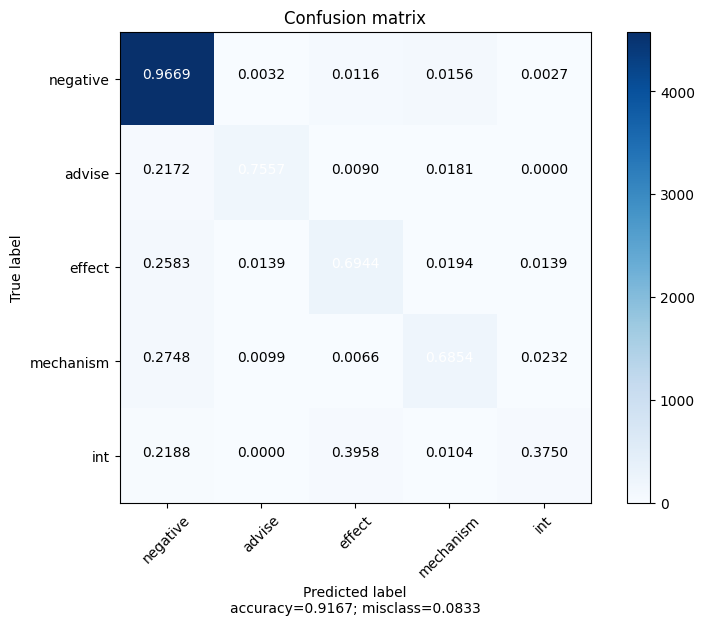

In [ ]:
-tgplot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True)